In [1]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import numpy as np
import geopandas as gpd
from shapely.geometry import MultiPolygon , Polygon
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium
from xgboost import Booster, XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [23]:
gdf = gpd.read_file('Taipei_grid.csv')
gdf.drop(gdf.columns[7:13],axis=1,inplace=True)
polygons = []
for i in range(gdf.shape[0]):
    gdf['geometry'][i] = Polygon(([(float(gdf['LeftBottom_x'][i]),float(gdf['LeftBottom_y'][i])), (float(gdf['LeftBottom_x'][i]),float(gdf['RightTop_y'][i])),(float(gdf['RightTop_x'][i]),float(gdf['RightTop_y'][i])), (float(gdf['RightTop_x'][i]),float(gdf['LeftBottom_y'][i]))]))
gdf.drop(gdf.columns[:7],axis=1,inplace=True)

In [2]:
#將所有格子分成五個不同的測試集
def split():
    gdf = gpd.read_file('Taipei_grid.csv')
    gdf.drop(gdf.columns[7:13],axis=1,inplace=True)
    polygons = []
    for i in range(gdf.shape[0]):
        gdf['geometry'][i] = Polygon(([(float(gdf['LeftBottom_x'][i]),float(gdf['LeftBottom_y'][i])), (float(gdf['LeftBottom_x'][i]),float(gdf['RightTop_y'][i])),(float(gdf['RightTop_x'][i]),float(gdf['RightTop_y'][i])), (float(gdf['RightTop_x'][i]),float(gdf['LeftBottom_y'][i]))]))
    gdf.drop(gdf.columns[:7],axis=1,inplace=True)
    
    
    da = gdf.index
    for i in range(5,1,-1):
        X_train,X_test,y_train,y_test = train_test_split(da,da,test_size=1/i,random_state=0)
        if i == 5:
            test1 = X_test.tolist()
            test1.sort()
        if i == 4:
            test2 = X_test.tolist()
            test2.sort()
        if i == 3:
            test3 = X_test.tolist()
            test3.sort()
        if i == 2:
            test4 = X_test.tolist()
            test4.sort()
            test5 = X_train.tolist()
            test5.sort()
        da = X_train 
        
        
    return test1,test2,test3,test4,test5


In [3]:
def all(mod,ls):
    pd.set_option('display.max_rows',None)
    #import data       
    gdf = gpd.read_file('Taipei_grid.csv')
    gdf.drop(gdf.columns[7:13],axis=1,inplace=True)
    polygons = []
    for i in range(gdf.shape[0]):
        gdf['geometry'][i] = Polygon(([(float(gdf['LeftBottom_x'][i]),float(gdf['LeftBottom_y'][i])), (float(gdf['LeftBottom_x'][i]),float(gdf['RightTop_y'][i])),(float(gdf['RightTop_x'][i]),float(gdf['RightTop_y'][i])), (float(gdf['RightTop_x'][i]),float(gdf['LeftBottom_y'][i]))]))
    gdf.drop(gdf.columns[:7],axis=1,inplace=True)

    
    gdf = gdf.loc[ls,:]

    # split data
    df = pd.read_csv('1.csv')
    df = df.drop(index=ls,axis=1)
    X_train,X_va,y_train,y_va = train_test_split(df.index,df.index,test_size=0.2,random_state=0)
    train = X_train.tolist()
    train.sort() #train index list
    
    validation = X_va.tolist()
    validation.sort() #validation index list

    
    # make training data
    for i in range(1,5):
        locals()['df'+str(i)] = pd.read_csv(str(i)+'.csv')
        locals()['df'+str(i)] = locals()['df'+str(i)].loc[train,:]        
    traindf = pd.concat([locals()['df'+str(1)],locals()['df'+str(2)],locals()['df'+str(3)],locals()['df'+str(4)]],axis=0)
    
    
    #make validation data
    for i in range(1,5):
        locals()['df'+str(i)] = pd.read_csv(str(i)+'.csv')
        locals()['df'+str(i)] = locals()['df'+str(i)].loc[validation,:]
    vadf = pd.concat([locals()['df'+str(1)],locals()['df'+str(2)],locals()['df'+str(3)],locals()['df'+str(4)]],axis=0)
    
    
    #make testing data
    df5 = pd.read_csv('5.csv')
    testdf = df5.loc[ls,:]
    
    
    #final data
    X_train = traindf.drop(labels=['bank','grid_id','college'],axis=1)
    y_train = traindf['bank'].values
    X_va = vadf.drop(labels=['bank','grid_id','college'],axis=1)
    y_va = vadf['bank'].values
    

    #train model
    m = mod()
    model = m.fit(X_train,y_train)
    pre = m.predict(X_va)
    va = mse(pre,y_va)
    print(f'{mod} :')
    print(f'validation : {va}')

    #test model
    x = testdf.drop(['bank','grid_id','college'],axis=1).values
    y = testdf['bank'].values

    pred = m.predict(x)
    test = mse(pred,y)
    print(f'test :　{test}')
    print()
    gdf['bpre'] = pred
    
    for i in range(len(pred)):
        pred[i] = round(pred[i])
        m = mse(pred,y)
    print('round :')
    print(m)
    print()
    
    gdf['real'] = y
    gdf['pre'] = pred
    
    change = []
    for i in ls:
        if int(gdf['real'][i]) != int(gdf['pre'][i]):
            change.append(1)
        else:
            change.append(0)  
    
    gdf['change'] = change
    
    cgdf = gdf[gdf['change']==1]
    print('change amount :')
    print(cgdf.shape[0])
    print()
    print('Accuracy :')
    print(f'{len(ls)-cgdf.shape[0]}/{len(ls)} = {(len(ls)-cgdf.shape[0])/len(ls)}')
    print()
    
    index = cgdf.index.tolist()
    future = []
    for i in index:
        if int(cgdf['pre'][i]) < int(cgdf['real'][i]):
            future.append('bed')
        else:
            future.append('good')

    cgdf['future'] = future
    
    print(gdf.head())
    print(cgdf.head())
    
    return gdf,cgdf,train,validation,m


In [4]:
def merg(gdf1,gdf2,gdf3,gdf4,gdf5,gdf6,gdf7,gdf8,gdf9,gdf10,mse1,mse2,mse3,mse4,mse5):
    
    gdf = pd.concat([gdf1,gdf2,gdf3,gdf4,gdf5],axis=0)
    gdf.sort_index(inplace=True)
    print(gdf.head(5))
    print(gdf.shape)
    cgdf = pd.concat([gdf6,gdf7,gdf8,gdf9,gdf10],axis=0)
    cgdf.sort_index(inplace=True)
    print(cgdf.head(5))
    print(cgdf.shape)
    print()
    
    mse = (mse1+mse2+mse3+mse4+mse5)/5
    print('mse : ')
    print(mse)
    
    return gdf,cgdf,mse


In [5]:
test1,test2,test3,test4,test5 = split()

In [51]:
testgdf1 = gdf.loc[test1,:]
testgdf2 = gdf.loc[test2,:]
testgdf3 = gdf.loc[test3,:]
testgdf4 = gdf.loc[test4,:]
testgdf5 = gdf.loc[test5,:]

In [52]:
for i in range(1,6):
    p = []
    for j in range(locals()['testgdf'+str(i)].shape[0]):
        p.append(i)
    locals()['testgdf'+str(i)]['part'] = p

In [55]:
allpart = pd.concat([testgdf1,testgdf2,testgdf3,testgdf4,testgdf5],axis=0)
allpart.sort_index(inplace=True)
print(allpart.shape)
allpart

(1221, 2)


,geometry,part
0,"POLYGON ((121.55786 25.21001, 121.55786 25.214...",2
1,"POLYGON ((121.55295 25.20550, 121.55295 25.210...",1
2,"POLYGON ((121.55786 25.20550, 121.55786 25.210...",4
3,"POLYGON ((121.56278 25.20550, 121.56278 25.210...",2
4,"POLYGON ((121.54803 25.20098, 121.54803 25.205...",3
5,"POLYGON ((121.55295 25.20098, 121.55295 25.205...",1
6,"POLYGON ((121.55786 25.20098, 121.55786 25.205...",2
7,"POLYGON ((121.56278 25.20098, 121.56278 25.205...",3
8,"POLYGON ((121.54312 25.19647, 121.54312 25.200...",1
9,"POLYGON ((121.54803 25.19647, 121.54803 25.200...",4


allpart.plot(column='part',legend=True,cmap='rainbow',figsize=(20,15),edgecolor='black')

co = {'1':'orange','2':'limegreen','3':'dodgerblue','4':'pink','5':'white'}
allpart.plot(column='part',cmap=colors.ListedColormap(list(co.values())),edgecolor='black',figsize=(20,15))


<AxesSubplot:>

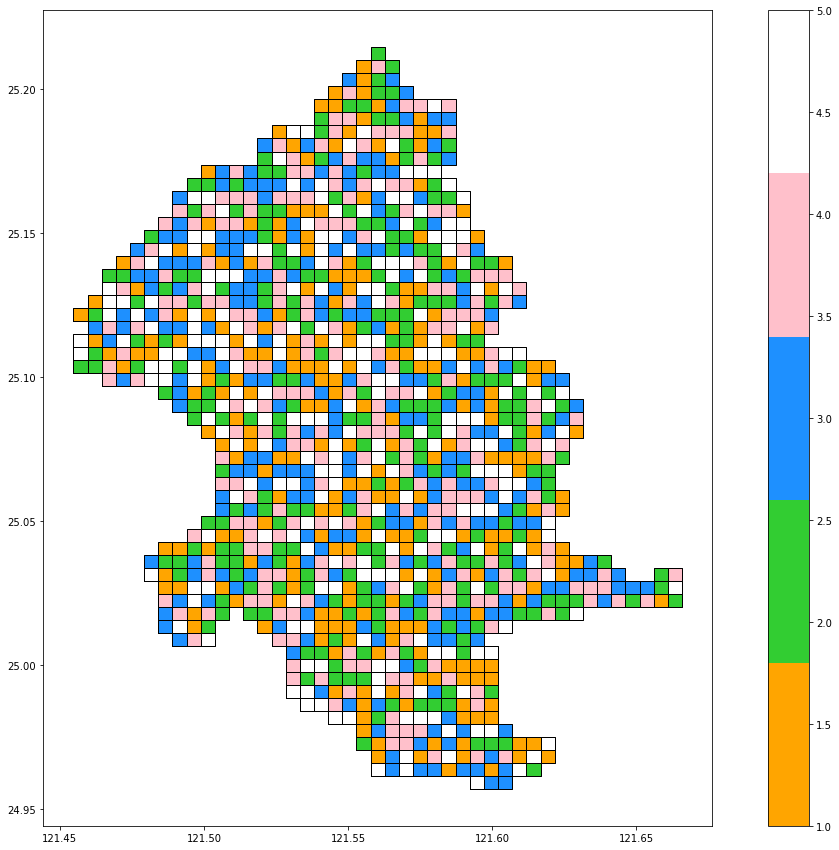

In [104]:
co = {'1':'orange','2':'limegreen','3':'dodgerblue','4':'pink','5':'white'}
allpart.plot(column='part',legend=True,cmap=colors.ListedColormap(list(co.values())),edgecolor='black',figsize=(20,15))


"\nax = testgdf1.plot(ax=ax,edgecolor='black',color='orange')\nax = testgdf2.plot(ax=ax,edgecolor='black',color='g')\nax = testgdf3.plot(ax=ax,edgecolor='black',color='cyan')\nax = testgdf4.plot(ax=ax,edgecolor='black',color='cadetblue')\nax = testgdf5.plot(ax=ax,edgecolor='black',color='red')\n"

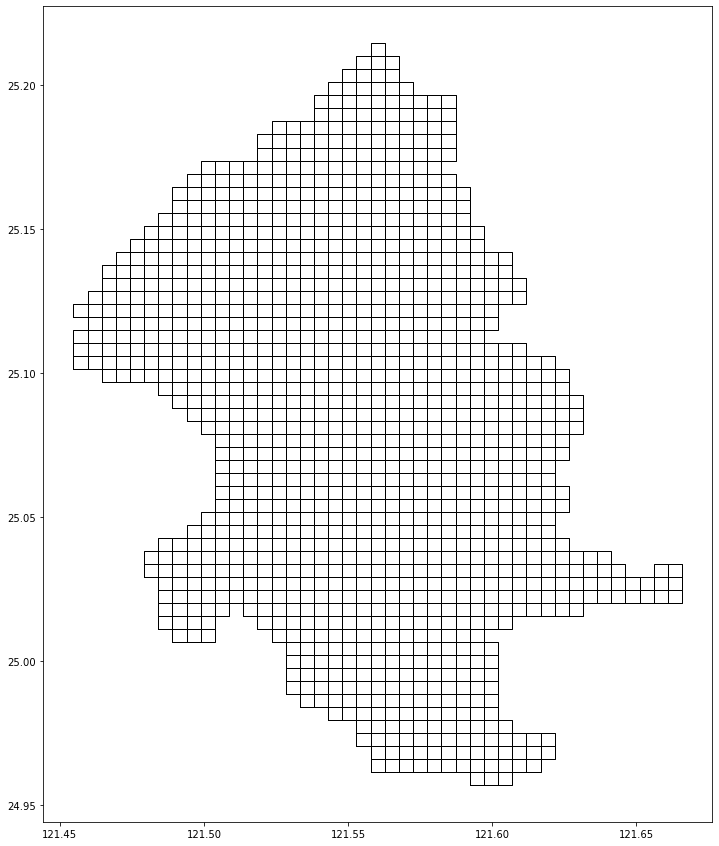

In [107]:
ax = gdf.plot(edgecolor='black',color='white',figsize=(20,15))
"""
ax = testgdf1.plot(ax=ax,edgecolor='black',color='orange')
ax = testgdf2.plot(ax=ax,edgecolor='black',color='g')
ax = testgdf3.plot(ax=ax,edgecolor='black',color='cyan')
ax = testgdf4.plot(ax=ax,edgecolor='black',color='cadetblue')
ax = testgdf5.plot(ax=ax,edgecolor='black',color='red')
"""

### XGboost

gdf1,cgdf1,train1,va1,mse1 = all(XGBRegressor,test1)

In [7]:
for i in range(1,6):
    locals()['gdf'+str(i)],locals()['cgdf'+str(i)],locals()['train'+str(i)],locals()['va'+str(i)],locals()['mse'+str(i)] = all(XGBRegressor,locals()['test'+str(i)])
    print(f'test{i} finished')

<class 'xgboost.sklearn.XGBRegressor'> :
validation : 2.154903671909507
test :　2.4863667834921266

round :
2.5142857142857142

change amount :
54

Accuracy :
191/245 = 0.7795918367346939

                                             geometry      bpre  real  pre  \
1   POLYGON ((121.55295 25.20550, 121.55295 25.210... -0.000613     0  0.0   
5   POLYGON ((121.55295 25.20098, 121.55295 25.205... -0.000613     0  0.0   
8   POLYGON ((121.54312 25.19647, 121.54312 25.200... -0.000613     0  0.0   
10  POLYGON ((121.55295 25.19647, 121.55295 25.200...  0.000215     0  0.0   
14  POLYGON ((121.53821 25.19195, 121.53821 25.196... -0.000613     0  0.0   

    change  
1        0  
5        0  
8        0  
10       0  
14       0  
                                              geometry      bpre  real  pre  \
268  POLYGON ((121.54312 25.13326, 121.54312 25.137... -0.064620     1  0.0   
311  POLYGON ((121.45958 25.12423, 121.45958 25.128...  0.044650     1  0.0   
351  POLYGON ((121.49889 25.

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<class 'xgboost.sklearn.XGBRegressor'> :
validation : 3.5246162956545333
test :　2.705024918552166

round :
2.7254098360655736

change amount :
44

Accuracy :
200/244 = 0.819672131147541

                                             geometry      bpre  real  pre  \
0   POLYGON ((121.55786 25.21001, 121.55786 25.214... -0.000464     0  0.0   
3   POLYGON ((121.56278 25.20550, 121.56278 25.210...  0.000003     0  0.0   
6   POLYGON ((121.55786 25.20098, 121.55786 25.205...  0.000019     0  0.0   
11  POLYGON ((121.55786 25.19647, 121.55786 25.200...  0.000019     0  0.0   
12  POLYGON ((121.56278 25.19647, 121.56278 25.200...  0.000003     0  0.0   

    change  
0        0  
3        0  
6        0  
11       0  
12       0  
                                              geometry      bpre  real  pre  \
252  POLYGON ((121.46450 25.13326, 121.46450 25.137...  0.535597     0  1.0   
325  POLYGON ((121.52838 25.12423, 121.52838 25.128... -0.045943     1  0.0   
357  POLYGON ((121.52838 25.1

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<class 'xgboost.sklearn.XGBRegressor'> :
validation : 4.160274661852519
test :　1.5009189180613975

round :
1.5614754098360655

change amount :
43

Accuracy :
201/244 = 0.8237704918032787

                                             geometry      bpre  real  pre  \
4   POLYGON ((121.54803 25.20098, 121.54803 25.205... -0.000249     0  0.0   
7   POLYGON ((121.56278 25.20098, 121.56278 25.205... -0.000769     0  0.0   
13  POLYGON ((121.56769 25.19647, 121.56769 25.200... -0.000769     0  0.0   
19  POLYGON ((121.56278 25.19195, 121.56278 25.196... -0.000769     0  0.0   
30  POLYGON ((121.56769 25.18744, 121.56769 25.191... -0.000769     0  0.0   

    change  
4        0  
7        0  
13       0  
19       0  
30       0  
                                              geometry      bpre  real  pre  \
232  POLYGON ((121.50872 25.13778, 121.50872 25.142...  1.017827     0  1.0   
414  POLYGON ((121.51855 25.11069, 121.51855 25.115...  0.899011     0  1.0   
476  POLYGON ((121.52346 25.

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<class 'xgboost.sklearn.XGBRegressor'> :
validation : 1.928110205115266
test :　2.047736823496117

round :
2.0860655737704916

change amount :
57

Accuracy :
187/244 = 0.7663934426229508

                                             geometry      bpre  real  pre  \
2   POLYGON ((121.55786 25.20550, 121.55786 25.210... -0.002668     0  0.0   
9   POLYGON ((121.54803 25.19647, 121.54803 25.200...  0.001017     0  0.0   
20  POLYGON ((121.56769 25.19195, 121.56769 25.196...  0.001295     0  0.0   
21  POLYGON ((121.57260 25.19195, 121.57260 25.196...  0.001295     0  0.0   
23  POLYGON ((121.58243 25.19195, 121.58243 25.196... -0.000480     0  0.0   

    change  
2        0  
9        0  
20       0  
21       0  
23       0  
                                              geometry      bpre  real  pre  \
230  POLYGON ((121.49889 25.13778, 121.49889 25.142...  0.769635     2  1.0   
287  POLYGON ((121.49398 25.12875, 121.49398 25.133...  0.964577     3  1.0   
319  POLYGON ((121.49889 25.1

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<class 'xgboost.sklearn.XGBRegressor'> :
validation : 2.5785428962777166
test :　2.6963887370529083

round :
2.8360655737704916

change amount :
56

Accuracy :
188/244 = 0.7704918032786885

                                             geometry      bpre  real  pre  \
22  POLYGON ((121.57752 25.19195, 121.57752 25.196...  0.001230     0  0.0   
35  POLYGON ((121.52838 25.18293, 121.52838 25.187... -0.001405     0  0.0   
36  POLYGON ((121.53329 25.18293, 121.53329 25.187...  0.000963     0  0.0   
40  POLYGON ((121.55295 25.18293, 121.55295 25.187...  0.000474     0  0.0   
53  POLYGON ((121.54803 25.17841, 121.54803 25.182...  0.000842     0  0.0   

    change  
22       0  
35       0  
36       0  
40       0  
53       0  
                                              geometry      bpre  real  pre  \
203  POLYGON ((121.49398 25.14229, 121.49398 25.146...  0.691781     0  1.0   
288  POLYGON ((121.49889 25.12875, 121.49889 25.133...  5.119229     4  5.0   
312  POLYGON ((121.46450 25

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
xggdf,xgcgdf,xgmse = merg(gdf1,gdf2,gdf3,gdf4,gdf5,cgdf1,cgdf2,cgdf3,cgdf4,cgdf5,mse1,mse2,mse3,mse4,mse5)

                                            geometry      bpre  real  pre  \
0  POLYGON ((121.55786 25.21001, 121.55786 25.214... -0.000464     0  0.0   
1  POLYGON ((121.55295 25.20550, 121.55295 25.210... -0.000613     0  0.0   
2  POLYGON ((121.55786 25.20550, 121.55786 25.210... -0.002668     0  0.0   
3  POLYGON ((121.56278 25.20550, 121.56278 25.210...  0.000003     0  0.0   
4  POLYGON ((121.54803 25.20098, 121.54803 25.205... -0.000249     0  0.0   

   change  
0       0  
1       0  
2       0  
3       0  
4       0  
(1221, 5)
                                              geometry      bpre  real  pre  \
203  POLYGON ((121.49398 25.14229, 121.49398 25.146...  0.691781     0  1.0   
230  POLYGON ((121.49889 25.13778, 121.49889 25.142...  0.769635     2  1.0   
232  POLYGON ((121.50872 25.13778, 121.50872 25.142...  1.017827     0  1.0   
252  POLYGON ((121.46450 25.13326, 121.46450 25.137...  0.535597     0  1.0   
268  POLYGON ((121.54312 25.13326, 121.54312 25.137... -0.06

In [10]:
print(xggdf.shape)
xggdf

(1221, 5)


,geometry,bpre,real,pre,change
0,"POLYGON ((121.55786 25.21001, 121.55786 25.214...",-0.000464,0,0.0,0
1,"POLYGON ((121.55295 25.20550, 121.55295 25.210...",-0.000613,0,0.0,0
2,"POLYGON ((121.55786 25.20550, 121.55786 25.210...",-0.002668,0,0.0,0
3,"POLYGON ((121.56278 25.20550, 121.56278 25.210...",0.000003,0,0.0,0
4,"POLYGON ((121.54803 25.20098, 121.54803 25.205...",-0.000249,0,0.0,0
5,"POLYGON ((121.55295 25.20098, 121.55295 25.205...",-0.000613,0,0.0,0
6,"POLYGON ((121.55786 25.20098, 121.55786 25.205...",0.000019,0,0.0,0
7,"POLYGON ((121.56278 25.20098, 121.56278 25.205...",-0.000769,0,0.0,0
8,"POLYGON ((121.54312 25.19647, 121.54312 25.200...",-0.000613,0,0.0,0
9,"POLYGON ((121.54803 25.19647, 121.54803 25.200...",0.001017,0,0.0,0


In [11]:
print(xgcgdf.shape)
xgcgdf

(254, 6)


,geometry,bpre,real,pre,change,future
203,"POLYGON ((121.49398 25.14229, 121.49398 25.146...",0.691781,0,1.0,1,good
230,"POLYGON ((121.49889 25.13778, 121.49889 25.142...",0.769635,2,1.0,1,bed
232,"POLYGON ((121.50872 25.13778, 121.50872 25.142...",1.017827,0,1.0,1,good
252,"POLYGON ((121.46450 25.13326, 121.46450 25.137...",0.535597,0,1.0,1,good
268,"POLYGON ((121.54312 25.13326, 121.54312 25.137...",-0.064620,1,0.0,1,bed
287,"POLYGON ((121.49398 25.12875, 121.49398 25.133...",0.964577,3,1.0,1,bed
288,"POLYGON ((121.49889 25.12875, 121.49889 25.133...",5.119229,4,5.0,1,good
311,"POLYGON ((121.45958 25.12423, 121.45958 25.128...",0.044650,1,0.0,1,bed
312,"POLYGON ((121.46450 25.12423, 121.46450 25.128...",0.887274,0,1.0,1,good
313,"POLYGON ((121.46941 25.12423, 121.46941 25.128...",6.567430,0,7.0,1,good


In [111]:
map = folium.Map(location = [25.055,121.55] , zoom_start = 12)
c = {'bed':'black','good':'red'}
xgcgdf.explore(m=map,column='future',cmap=colors.ListedColormap(list(c.values())))

Text(0.5, 1.0, 'XGboost')

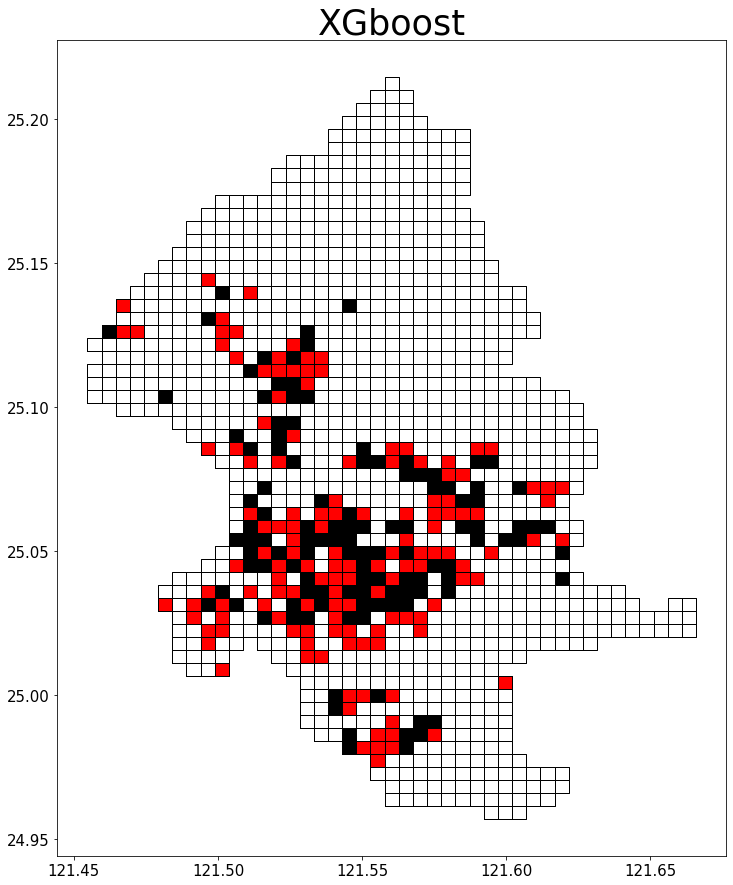

In [148]:
ax = gdf.plot(edgecolor='black',color='white',figsize=(20,15))
c = {'bed':'black','good':'red'}
xgcgdf.plot(ax=ax,column='future',edgecolor='black',cmap=colors.ListedColormap(list(c.values())))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('XGboost',fontsize=35)

In [131]:
real = gpd.read_file('real.shp')

<AxesSubplot:>

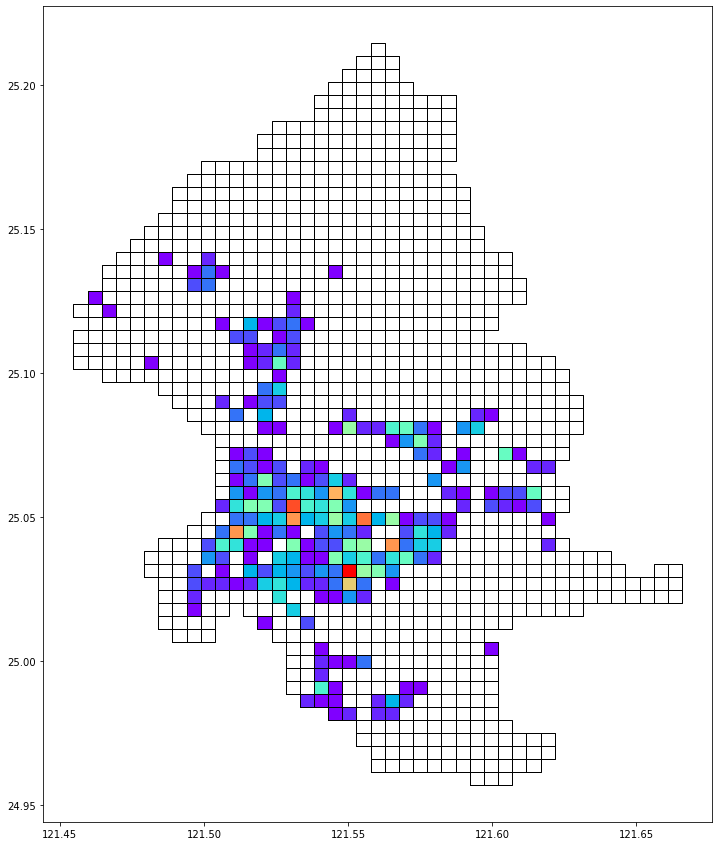

In [133]:
ax = gdf.plot(edgecolor='black',color='white',figsize=(20,15))
real.plot(ax=ax,column='real',edgecolor='black',cmap='rainbow')

In [136]:
double = real.overlay(xgcgdf,how="intersection")
double

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:2197: UserWarning: `keep_geom_type=True` in overlay resulted in 1137 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  self, right, how=how, keep_geom_type=keep_geom_type, make_valid=make_valid


,real_1,pre_1,bpre,real_2,pre_2,change,future,geometry
0,2,2.0,0.769635,2,1.0,1,bed,"POLYGON ((121.49889 25.14229, 121.50381 25.142..."
1,3,3.0,0.964577,3,1.0,1,bed,"POLYGON ((121.49398 25.13326, 121.49889 25.133..."
2,4,4.0,5.119229,4,5.0,1,good,"POLYGON ((121.49889 25.13326, 121.50381 25.133..."
3,1,1.0,-0.064620,1,0.0,1,bed,"POLYGON ((121.54312 25.13778, 121.54803 25.137..."
4,1,1.0,0.044650,1,0.0,1,bed,"POLYGON ((121.45958 25.12875, 121.46450 25.128..."
5,1,1.0,-0.045943,1,0.0,1,bed,"POLYGON ((121.52838 25.12875, 121.53329 25.128..."
6,2,2.0,0.715099,2,1.0,1,bed,"POLYGON ((121.52838 25.12423, 121.53329 25.124..."
7,3,3.0,0.513727,3,1.0,1,bed,"POLYGON ((121.52346 25.11972, 121.52838 25.119..."
8,4,5.0,5.048121,4,5.0,1,good,"POLYGON ((121.52838 25.11972, 121.53329 25.119..."
9,1,1.0,2.666494,1,3.0,1,good,"POLYGON ((121.53329 25.11972, 121.53821 25.119..."


<AxesSubplot:>

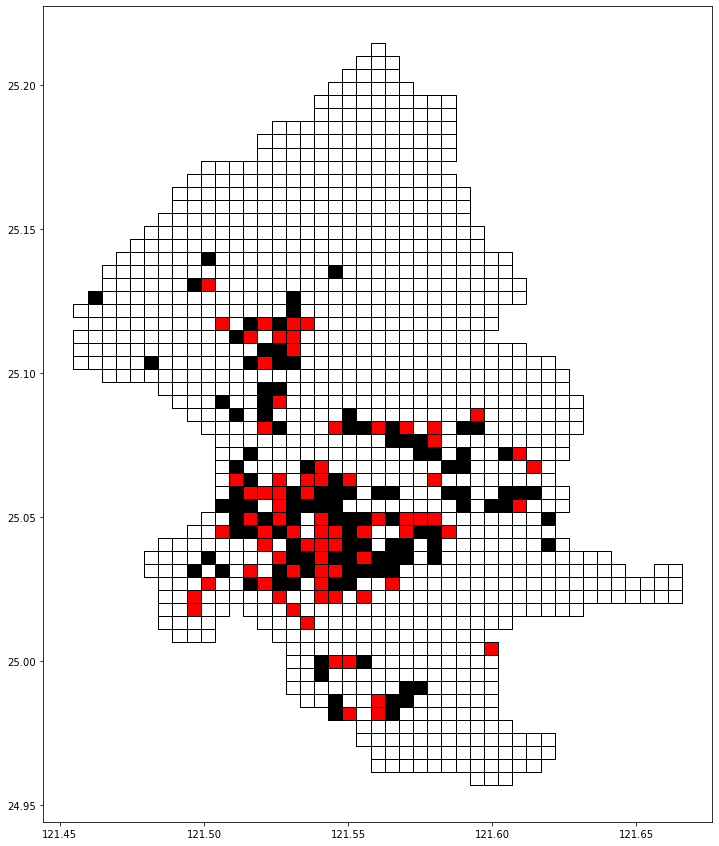

In [135]:
ax = gdf.plot(edgecolor='black',color='white',figsize=(20,15))
double.plot(ax=ax,column='future',edgecolor='black',cmap=colors.ListedColormap(list(c.values())))

### Catboost

In [13]:
for i in range(1,6):
    locals()['gdf'+str(i)],locals()['cgdf'+str(i)],locals()['train'+str(i)],locals()['va'+str(i)],locals()['mse'+str(i)] = all(CatBoostRegressor,locals()['test'+str(i)])
    print(f'test{i} finished')

Learning rate set to 0.047793
0:	learn: 2.1714831	total: 131ms	remaining: 2m 10s
1:	learn: 2.1023021	total: 132ms	remaining: 1m 5s
2:	learn: 2.0372573	total: 133ms	remaining: 44.3s
3:	learn: 1.9711692	total: 135ms	remaining: 33.5s
4:	learn: 1.9116316	total: 136ms	remaining: 27s
5:	learn: 1.8525087	total: 137ms	remaining: 22.7s
6:	learn: 1.7966654	total: 138ms	remaining: 19.6s
7:	learn: 1.7414489	total: 139ms	remaining: 17.3s
8:	learn: 1.6902367	total: 140ms	remaining: 15.4s
9:	learn: 1.6414348	total: 141ms	remaining: 14s
10:	learn: 1.5943041	total: 142ms	remaining: 12.8s
11:	learn: 1.5536820	total: 144ms	remaining: 11.8s
12:	learn: 1.5147222	total: 145ms	remaining: 11s
13:	learn: 1.4752923	total: 146ms	remaining: 10.3s
14:	learn: 1.4371764	total: 147ms	remaining: 9.64s
15:	learn: 1.4029703	total: 148ms	remaining: 9.1s
16:	learn: 1.3715850	total: 149ms	remaining: 8.62s
17:	learn: 1.3391483	total: 150ms	remaining: 8.19s
18:	learn: 1.3089676	total: 151ms	remaining: 7.81s
19:	learn: 1.2778

180:	learn: 0.3155833	total: 346ms	remaining: 1.57s
181:	learn: 0.3129330	total: 348ms	remaining: 1.56s
182:	learn: 0.3118790	total: 349ms	remaining: 1.56s
183:	learn: 0.3107979	total: 350ms	remaining: 1.55s
184:	learn: 0.3095055	total: 351ms	remaining: 1.55s
185:	learn: 0.3082107	total: 352ms	remaining: 1.54s
186:	learn: 0.3060040	total: 354ms	remaining: 1.54s
187:	learn: 0.3040956	total: 355ms	remaining: 1.53s
188:	learn: 0.3031035	total: 356ms	remaining: 1.53s
189:	learn: 0.3017929	total: 358ms	remaining: 1.52s
190:	learn: 0.3009500	total: 359ms	remaining: 1.52s
191:	learn: 0.3003204	total: 361ms	remaining: 1.52s
192:	learn: 0.2990589	total: 362ms	remaining: 1.51s
193:	learn: 0.2984133	total: 363ms	remaining: 1.51s
194:	learn: 0.2967630	total: 364ms	remaining: 1.5s
195:	learn: 0.2966414	total: 365ms	remaining: 1.5s
196:	learn: 0.2951050	total: 366ms	remaining: 1.49s
197:	learn: 0.2933901	total: 367ms	remaining: 1.49s
198:	learn: 0.2922110	total: 368ms	remaining: 1.48s
199:	learn: 0.

458:	learn: 0.0983381	total: 678ms	remaining: 799ms
459:	learn: 0.0980731	total: 679ms	remaining: 797ms
460:	learn: 0.0978347	total: 680ms	remaining: 795ms
461:	learn: 0.0976645	total: 681ms	remaining: 793ms
462:	learn: 0.0974636	total: 682ms	remaining: 791ms
463:	learn: 0.0970547	total: 684ms	remaining: 790ms
464:	learn: 0.0969013	total: 685ms	remaining: 788ms
465:	learn: 0.0964346	total: 686ms	remaining: 786ms
466:	learn: 0.0962937	total: 687ms	remaining: 784ms
467:	learn: 0.0960546	total: 688ms	remaining: 782ms
468:	learn: 0.0956755	total: 689ms	remaining: 780ms
469:	learn: 0.0955101	total: 691ms	remaining: 779ms
470:	learn: 0.0954243	total: 692ms	remaining: 777ms
471:	learn: 0.0952442	total: 693ms	remaining: 775ms
472:	learn: 0.0946343	total: 694ms	remaining: 773ms
473:	learn: 0.0944078	total: 695ms	remaining: 772ms
474:	learn: 0.0942912	total: 697ms	remaining: 770ms
475:	learn: 0.0940730	total: 698ms	remaining: 768ms
476:	learn: 0.0938575	total: 699ms	remaining: 766ms
477:	learn: 

736:	learn: 0.0534167	total: 1.02s	remaining: 363ms
737:	learn: 0.0533184	total: 1.02s	remaining: 362ms
738:	learn: 0.0532212	total: 1.02s	remaining: 360ms
739:	learn: 0.0531812	total: 1.02s	remaining: 359ms
740:	learn: 0.0531026	total: 1.02s	remaining: 357ms
741:	learn: 0.0530010	total: 1.02s	remaining: 356ms
742:	learn: 0.0528837	total: 1.02s	remaining: 355ms
743:	learn: 0.0527945	total: 1.03s	remaining: 353ms
744:	learn: 0.0527423	total: 1.03s	remaining: 352ms
745:	learn: 0.0526562	total: 1.03s	remaining: 350ms
746:	learn: 0.0525179	total: 1.03s	remaining: 349ms
747:	learn: 0.0524388	total: 1.03s	remaining: 348ms
748:	learn: 0.0522393	total: 1.03s	remaining: 346ms
749:	learn: 0.0521532	total: 1.03s	remaining: 345ms
750:	learn: 0.0521248	total: 1.03s	remaining: 343ms
751:	learn: 0.0520757	total: 1.04s	remaining: 342ms
752:	learn: 0.0520346	total: 1.04s	remaining: 341ms
753:	learn: 0.0519608	total: 1.04s	remaining: 339ms
754:	learn: 0.0518846	total: 1.04s	remaining: 338ms
755:	learn: 

round :
2.1714285714285713

change amount :
50

Accuracy :
195/245 = 0.7959183673469388

                                             geometry      bpre  real  pre  \
1   POLYGON ((121.55295 25.20550, 121.55295 25.210... -0.014783     0  0.0   
5   POLYGON ((121.55295 25.20098, 121.55295 25.205... -0.014783     0  0.0   
8   POLYGON ((121.54312 25.19647, 121.54312 25.200... -0.014783     0  0.0   
10  POLYGON ((121.55295 25.19647, 121.55295 25.200... -0.000650     0  0.0   
14  POLYGON ((121.53821 25.19195, 121.53821 25.196... -0.003923     0  0.0   

    change  
1        0  
5        0  
8        0  
10       0  
14       0  
                                              geometry      bpre  real  pre  \
268  POLYGON ((121.54312 25.13326, 121.54312 25.137...  0.023165     1  0.0   
311  POLYGON ((121.45958 25.12423, 121.45958 25.128...  0.022134     1  0.0   
356  POLYGON ((121.52346 25.11972, 121.52346 25.124...  0.891516     0  1.0   
381  POLYGON ((121.50381 25.11521, 121.50381 25.

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Learning rate set to 0.047803
0:	learn: 2.2146847	total: 1.29ms	remaining: 1.29s
1:	learn: 2.1470342	total: 2.6ms	remaining: 1.3s
2:	learn: 2.0779890	total: 3.67ms	remaining: 1.22s
3:	learn: 2.0138578	total: 4.73ms	remaining: 1.18s
4:	learn: 1.9540438	total: 5.75ms	remaining: 1.14s
5:	learn: 1.8938798	total: 6.8ms	remaining: 1.13s
6:	learn: 1.8391174	total: 7.87ms	remaining: 1.11s
7:	learn: 1.7833459	total: 8.9ms	remaining: 1.1s
8:	learn: 1.7323045	total: 9.97ms	remaining: 1.1s
9:	learn: 1.6842240	total: 11ms	remaining: 1.09s
10:	learn: 1.6372484	total: 12.1ms	remaining: 1.08s
11:	learn: 1.5923100	total: 13.1ms	remaining: 1.08s
12:	learn: 1.5501425	total: 14.1ms	remaining: 1.07s
13:	learn: 1.5079057	total: 15.2ms	remaining: 1.07s
14:	learn: 1.4695551	total: 16.3ms	remaining: 1.07s
15:	learn: 1.4327812	total: 17.4ms	remaining: 1.07s
16:	learn: 1.3964010	total: 18.6ms	remaining: 1.08s
17:	learn: 1.3591589	total: 19.7ms	remaining: 1.07s
18:	learn: 1.3246366	total: 20.8ms	remaining: 1.07s


289:	learn: 0.1841662	total: 328ms	remaining: 804ms
290:	learn: 0.1835962	total: 330ms	remaining: 803ms
291:	learn: 0.1830045	total: 331ms	remaining: 802ms
292:	learn: 0.1822119	total: 332ms	remaining: 801ms
293:	learn: 0.1817910	total: 333ms	remaining: 800ms
294:	learn: 0.1816544	total: 334ms	remaining: 799ms
295:	learn: 0.1814667	total: 335ms	remaining: 798ms
296:	learn: 0.1805377	total: 337ms	remaining: 797ms
297:	learn: 0.1797735	total: 338ms	remaining: 796ms
298:	learn: 0.1793216	total: 339ms	remaining: 796ms
299:	learn: 0.1781610	total: 341ms	remaining: 795ms
300:	learn: 0.1774031	total: 342ms	remaining: 794ms
301:	learn: 0.1770525	total: 343ms	remaining: 793ms
302:	learn: 0.1769332	total: 344ms	remaining: 791ms
303:	learn: 0.1764268	total: 345ms	remaining: 790ms
304:	learn: 0.1762993	total: 346ms	remaining: 789ms
305:	learn: 0.1752788	total: 347ms	remaining: 788ms
306:	learn: 0.1740618	total: 349ms	remaining: 787ms
307:	learn: 0.1738946	total: 349ms	remaining: 785ms
308:	learn: 

566:	learn: 0.0841719	total: 661ms	remaining: 505ms
567:	learn: 0.0838629	total: 662ms	remaining: 504ms
568:	learn: 0.0836176	total: 663ms	remaining: 502ms
569:	learn: 0.0833042	total: 664ms	remaining: 501ms
570:	learn: 0.0831614	total: 666ms	remaining: 500ms
571:	learn: 0.0830493	total: 667ms	remaining: 499ms
572:	learn: 0.0829435	total: 668ms	remaining: 498ms
573:	learn: 0.0827751	total: 669ms	remaining: 497ms
574:	learn: 0.0825575	total: 671ms	remaining: 496ms
575:	learn: 0.0824235	total: 672ms	remaining: 495ms
576:	learn: 0.0823380	total: 673ms	remaining: 493ms
577:	learn: 0.0821085	total: 674ms	remaining: 492ms
578:	learn: 0.0820148	total: 675ms	remaining: 491ms
579:	learn: 0.0818719	total: 677ms	remaining: 490ms
580:	learn: 0.0816435	total: 678ms	remaining: 489ms
581:	learn: 0.0815276	total: 680ms	remaining: 488ms
582:	learn: 0.0812634	total: 681ms	remaining: 487ms
583:	learn: 0.0811807	total: 682ms	remaining: 486ms
584:	learn: 0.0810626	total: 684ms	remaining: 485ms
585:	learn: 

861:	learn: 0.0510302	total: 1.01s	remaining: 162ms
862:	learn: 0.0509567	total: 1.01s	remaining: 160ms
863:	learn: 0.0508997	total: 1.01s	remaining: 159ms
864:	learn: 0.0508720	total: 1.01s	remaining: 158ms
865:	learn: 0.0508069	total: 1.01s	remaining: 157ms
866:	learn: 0.0506881	total: 1.01s	remaining: 156ms
867:	learn: 0.0505696	total: 1.02s	remaining: 155ms
868:	learn: 0.0505143	total: 1.02s	remaining: 153ms
869:	learn: 0.0504663	total: 1.02s	remaining: 152ms
870:	learn: 0.0504221	total: 1.02s	remaining: 151ms
871:	learn: 0.0503797	total: 1.02s	remaining: 150ms
872:	learn: 0.0503536	total: 1.02s	remaining: 149ms
873:	learn: 0.0503122	total: 1.02s	remaining: 148ms
874:	learn: 0.0502720	total: 1.03s	remaining: 147ms
875:	learn: 0.0502406	total: 1.03s	remaining: 145ms
876:	learn: 0.0501287	total: 1.03s	remaining: 144ms
877:	learn: 0.0500865	total: 1.03s	remaining: 143ms
878:	learn: 0.0499964	total: 1.03s	remaining: 142ms
879:	learn: 0.0499718	total: 1.03s	remaining: 141ms
880:	learn: 

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Learning rate set to 0.047803
0:	learn: 2.3357273	total: 1.48ms	remaining: 1.47s
1:	learn: 2.2630526	total: 2.74ms	remaining: 1.37s
2:	learn: 2.1932813	total: 3.82ms	remaining: 1.27s
3:	learn: 2.1219885	total: 4.89ms	remaining: 1.22s
4:	learn: 2.0537297	total: 5.98ms	remaining: 1.19s
5:	learn: 1.9905336	total: 7.24ms	remaining: 1.2s
6:	learn: 1.9291066	total: 8.69ms	remaining: 1.23s
7:	learn: 1.8681970	total: 9.77ms	remaining: 1.21s
8:	learn: 1.8091652	total: 10.9ms	remaining: 1.2s
9:	learn: 1.7582154	total: 12ms	remaining: 1.19s
10:	learn: 1.7097839	total: 13.1ms	remaining: 1.18s
11:	learn: 1.6574911	total: 14.1ms	remaining: 1.16s
12:	learn: 1.6121441	total: 15.3ms	remaining: 1.16s
13:	learn: 1.5680157	total: 16.3ms	remaining: 1.15s
14:	learn: 1.5260760	total: 17.4ms	remaining: 1.14s
15:	learn: 1.4825866	total: 18.5ms	remaining: 1.14s
16:	learn: 1.4433789	total: 19.5ms	remaining: 1.13s
17:	learn: 1.4030814	total: 20.6ms	remaining: 1.12s
18:	learn: 1.3672777	total: 21.7ms	remaining: 1.

282:	learn: 0.2239863	total: 339ms	remaining: 860ms
283:	learn: 0.2229530	total: 341ms	remaining: 859ms
284:	learn: 0.2225470	total: 342ms	remaining: 858ms
285:	learn: 0.2218297	total: 343ms	remaining: 857ms
286:	learn: 0.2215374	total: 344ms	remaining: 856ms
287:	learn: 0.2208485	total: 346ms	remaining: 854ms
288:	learn: 0.2200732	total: 347ms	remaining: 853ms
289:	learn: 0.2194724	total: 348ms	remaining: 852ms
290:	learn: 0.2181590	total: 349ms	remaining: 851ms
291:	learn: 0.2176260	total: 350ms	remaining: 849ms
292:	learn: 0.2170191	total: 351ms	remaining: 848ms
293:	learn: 0.2165885	total: 352ms	remaining: 846ms
294:	learn: 0.2156128	total: 354ms	remaining: 845ms
295:	learn: 0.2149228	total: 358ms	remaining: 851ms
296:	learn: 0.2146327	total: 359ms	remaining: 850ms
297:	learn: 0.2144107	total: 360ms	remaining: 849ms
298:	learn: 0.2137721	total: 362ms	remaining: 848ms
299:	learn: 0.2135398	total: 363ms	remaining: 847ms
300:	learn: 0.2132561	total: 364ms	remaining: 845ms
301:	learn: 

564:	learn: 0.1069446	total: 687ms	remaining: 529ms
565:	learn: 0.1066094	total: 688ms	remaining: 528ms
566:	learn: 0.1061596	total: 690ms	remaining: 527ms
567:	learn: 0.1060546	total: 691ms	remaining: 525ms
568:	learn: 0.1056314	total: 692ms	remaining: 524ms
569:	learn: 0.1055752	total: 693ms	remaining: 523ms
570:	learn: 0.1054532	total: 694ms	remaining: 522ms
571:	learn: 0.1050609	total: 696ms	remaining: 521ms
572:	learn: 0.1049895	total: 697ms	remaining: 519ms
573:	learn: 0.1048728	total: 698ms	remaining: 518ms
574:	learn: 0.1047654	total: 700ms	remaining: 517ms
575:	learn: 0.1046224	total: 701ms	remaining: 516ms
576:	learn: 0.1043107	total: 703ms	remaining: 515ms
577:	learn: 0.1042002	total: 704ms	remaining: 514ms
578:	learn: 0.1038439	total: 705ms	remaining: 513ms
579:	learn: 0.1035979	total: 706ms	remaining: 511ms
580:	learn: 0.1032592	total: 707ms	remaining: 510ms
581:	learn: 0.1031994	total: 709ms	remaining: 509ms
582:	learn: 0.1028908	total: 710ms	remaining: 508ms
583:	learn: 

850:	learn: 0.0713796	total: 1.02s	remaining: 179ms
851:	learn: 0.0712689	total: 1.02s	remaining: 178ms
852:	learn: 0.0712263	total: 1.03s	remaining: 177ms
853:	learn: 0.0710707	total: 1.03s	remaining: 176ms
854:	learn: 0.0709635	total: 1.03s	remaining: 175ms
855:	learn: 0.0707729	total: 1.03s	remaining: 173ms
856:	learn: 0.0705784	total: 1.03s	remaining: 172ms
857:	learn: 0.0703928	total: 1.03s	remaining: 171ms
858:	learn: 0.0702939	total: 1.03s	remaining: 170ms
859:	learn: 0.0701917	total: 1.04s	remaining: 169ms
860:	learn: 0.0701834	total: 1.04s	remaining: 168ms
861:	learn: 0.0700956	total: 1.04s	remaining: 166ms
862:	learn: 0.0700633	total: 1.04s	remaining: 165ms
863:	learn: 0.0698957	total: 1.04s	remaining: 164ms
864:	learn: 0.0698536	total: 1.04s	remaining: 163ms
865:	learn: 0.0696805	total: 1.04s	remaining: 162ms
866:	learn: 0.0696382	total: 1.04s	remaining: 160ms
867:	learn: 0.0696197	total: 1.05s	remaining: 159ms
868:	learn: 0.0695875	total: 1.05s	remaining: 158ms
869:	learn: 

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Learning rate set to 0.047803
0:	learn: 2.4173195	total: 14.3ms	remaining: 14.3s
1:	learn: 2.3423018	total: 15.7ms	remaining: 7.84s
2:	learn: 2.2678776	total: 16.8ms	remaining: 5.6s
3:	learn: 2.1998155	total: 17.9ms	remaining: 4.45s
4:	learn: 2.1327750	total: 19ms	remaining: 3.78s
5:	learn: 2.0651610	total: 20ms	remaining: 3.32s
6:	learn: 2.0082163	total: 21.2ms	remaining: 3s
7:	learn: 1.9486201	total: 22.2ms	remaining: 2.76s
8:	learn: 1.8929976	total: 23.3ms	remaining: 2.56s
9:	learn: 1.8383152	total: 24.4ms	remaining: 2.42s
10:	learn: 1.7828246	total: 25.5ms	remaining: 2.29s
11:	learn: 1.7355795	total: 26.5ms	remaining: 2.19s
12:	learn: 1.6891575	total: 27.6ms	remaining: 2.09s
13:	learn: 1.6485241	total: 28.6ms	remaining: 2.02s
14:	learn: 1.6059396	total: 29.7ms	remaining: 1.95s
15:	learn: 1.5642702	total: 30.8ms	remaining: 1.9s
16:	learn: 1.5273202	total: 31.9ms	remaining: 1.84s
17:	learn: 1.4859835	total: 33ms	remaining: 1.8s
18:	learn: 1.4498873	total: 34.1ms	remaining: 1.76s
19:	

283:	learn: 0.2139033	total: 336ms	remaining: 848ms
284:	learn: 0.2131777	total: 338ms	remaining: 847ms
285:	learn: 0.2120848	total: 339ms	remaining: 846ms
286:	learn: 0.2107268	total: 340ms	remaining: 845ms
287:	learn: 0.2097113	total: 341ms	remaining: 844ms
288:	learn: 0.2089182	total: 343ms	remaining: 843ms
289:	learn: 0.2080312	total: 344ms	remaining: 842ms
290:	learn: 0.2072128	total: 345ms	remaining: 840ms
291:	learn: 0.2066524	total: 346ms	remaining: 839ms
292:	learn: 0.2061307	total: 347ms	remaining: 838ms
293:	learn: 0.2052847	total: 349ms	remaining: 838ms
294:	learn: 0.2044612	total: 351ms	remaining: 838ms
295:	learn: 0.2040437	total: 352ms	remaining: 837ms
296:	learn: 0.2029171	total: 353ms	remaining: 836ms
297:	learn: 0.2013426	total: 354ms	remaining: 834ms
298:	learn: 0.2004782	total: 355ms	remaining: 833ms
299:	learn: 0.1991416	total: 356ms	remaining: 832ms
300:	learn: 0.1990245	total: 358ms	remaining: 830ms
301:	learn: 0.1985606	total: 359ms	remaining: 829ms
302:	learn: 

577:	learn: 0.0863673	total: 686ms	remaining: 501ms
578:	learn: 0.0861280	total: 687ms	remaining: 500ms
579:	learn: 0.0859700	total: 688ms	remaining: 498ms
580:	learn: 0.0857357	total: 689ms	remaining: 497ms
581:	learn: 0.0855851	total: 691ms	remaining: 496ms
582:	learn: 0.0853414	total: 692ms	remaining: 495ms
583:	learn: 0.0851211	total: 693ms	remaining: 494ms
584:	learn: 0.0850557	total: 694ms	remaining: 492ms
585:	learn: 0.0849037	total: 695ms	remaining: 491ms
586:	learn: 0.0846895	total: 697ms	remaining: 490ms
587:	learn: 0.0845094	total: 698ms	remaining: 489ms
588:	learn: 0.0843324	total: 700ms	remaining: 488ms
589:	learn: 0.0841269	total: 701ms	remaining: 487ms
590:	learn: 0.0839789	total: 702ms	remaining: 486ms
591:	learn: 0.0838203	total: 703ms	remaining: 485ms
592:	learn: 0.0837033	total: 704ms	remaining: 483ms
593:	learn: 0.0836544	total: 706ms	remaining: 482ms
594:	learn: 0.0836116	total: 707ms	remaining: 481ms
595:	learn: 0.0835928	total: 708ms	remaining: 480ms
596:	learn: 

878:	learn: 0.0559164	total: 1.03s	remaining: 143ms
879:	learn: 0.0558175	total: 1.04s	remaining: 141ms
880:	learn: 0.0557392	total: 1.04s	remaining: 140ms
881:	learn: 0.0556835	total: 1.04s	remaining: 139ms
882:	learn: 0.0555935	total: 1.04s	remaining: 138ms
883:	learn: 0.0555485	total: 1.04s	remaining: 137ms
884:	learn: 0.0554772	total: 1.04s	remaining: 136ms
885:	learn: 0.0554488	total: 1.04s	remaining: 134ms
886:	learn: 0.0554053	total: 1.04s	remaining: 133ms
887:	learn: 0.0553088	total: 1.05s	remaining: 132ms
888:	learn: 0.0552419	total: 1.05s	remaining: 131ms
889:	learn: 0.0551370	total: 1.05s	remaining: 130ms
890:	learn: 0.0550639	total: 1.05s	remaining: 129ms
891:	learn: 0.0549624	total: 1.05s	remaining: 127ms
892:	learn: 0.0548816	total: 1.05s	remaining: 126ms
893:	learn: 0.0547816	total: 1.05s	remaining: 125ms
894:	learn: 0.0547052	total: 1.05s	remaining: 124ms
895:	learn: 0.0546352	total: 1.06s	remaining: 123ms
896:	learn: 0.0545608	total: 1.06s	remaining: 121ms
897:	learn: 

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Learning rate set to 0.047803
0:	learn: 2.3363420	total: 9.58ms	remaining: 9.57s
1:	learn: 2.2679500	total: 10.8ms	remaining: 5.41s
2:	learn: 2.1996149	total: 11.9ms	remaining: 3.95s
3:	learn: 2.1290256	total: 12.9ms	remaining: 3.22s
4:	learn: 2.0681912	total: 14.1ms	remaining: 2.8s
5:	learn: 2.0030794	total: 15.2ms	remaining: 2.52s
6:	learn: 1.9392668	total: 16.4ms	remaining: 2.32s
7:	learn: 1.8918688	total: 17.4ms	remaining: 2.16s
8:	learn: 1.8341856	total: 18.5ms	remaining: 2.04s
9:	learn: 1.7818448	total: 19.7ms	remaining: 1.95s
10:	learn: 1.7315698	total: 20.9ms	remaining: 1.88s
11:	learn: 1.6855539	total: 22ms	remaining: 1.81s
12:	learn: 1.6417929	total: 23.1ms	remaining: 1.75s
13:	learn: 1.5982845	total: 24.1ms	remaining: 1.7s
14:	learn: 1.5548017	total: 25.2ms	remaining: 1.66s
15:	learn: 1.5135626	total: 26.3ms	remaining: 1.62s
16:	learn: 1.4734018	total: 27.4ms	remaining: 1.58s
17:	learn: 1.4353481	total: 28.5ms	remaining: 1.56s
18:	learn: 1.3972833	total: 29.7ms	remaining: 1.

270:	learn: 0.1999944	total: 335ms	remaining: 901ms
271:	learn: 0.1984510	total: 336ms	remaining: 900ms
272:	learn: 0.1977778	total: 338ms	remaining: 899ms
273:	learn: 0.1970933	total: 339ms	remaining: 898ms
274:	learn: 0.1965540	total: 340ms	remaining: 896ms
275:	learn: 0.1954471	total: 341ms	remaining: 895ms
276:	learn: 0.1947864	total: 343ms	remaining: 894ms
277:	learn: 0.1941269	total: 344ms	remaining: 893ms
278:	learn: 0.1935009	total: 345ms	remaining: 891ms
279:	learn: 0.1930610	total: 346ms	remaining: 890ms
280:	learn: 0.1925641	total: 347ms	remaining: 888ms
281:	learn: 0.1917338	total: 349ms	remaining: 887ms
282:	learn: 0.1902070	total: 350ms	remaining: 887ms
283:	learn: 0.1896014	total: 351ms	remaining: 886ms
284:	learn: 0.1887215	total: 354ms	remaining: 887ms
285:	learn: 0.1880378	total: 355ms	remaining: 886ms
286:	learn: 0.1872044	total: 356ms	remaining: 885ms
287:	learn: 0.1858730	total: 357ms	remaining: 884ms
288:	learn: 0.1850406	total: 359ms	remaining: 882ms
289:	learn: 

539:	learn: 0.0877463	total: 674ms	remaining: 575ms
540:	learn: 0.0877201	total: 676ms	remaining: 573ms
541:	learn: 0.0874122	total: 677ms	remaining: 572ms
542:	learn: 0.0873865	total: 678ms	remaining: 571ms
543:	learn: 0.0871829	total: 679ms	remaining: 569ms
544:	learn: 0.0868891	total: 680ms	remaining: 568ms
545:	learn: 0.0867421	total: 682ms	remaining: 567ms
546:	learn: 0.0866784	total: 683ms	remaining: 565ms
547:	learn: 0.0865835	total: 684ms	remaining: 564ms
548:	learn: 0.0865246	total: 685ms	remaining: 563ms
549:	learn: 0.0863242	total: 686ms	remaining: 562ms
550:	learn: 0.0859798	total: 688ms	remaining: 560ms
551:	learn: 0.0859457	total: 689ms	remaining: 559ms
552:	learn: 0.0857758	total: 690ms	remaining: 558ms
553:	learn: 0.0854885	total: 691ms	remaining: 556ms
554:	learn: 0.0852100	total: 692ms	remaining: 555ms
555:	learn: 0.0851332	total: 694ms	remaining: 554ms
556:	learn: 0.0847848	total: 695ms	remaining: 553ms
557:	learn: 0.0845929	total: 696ms	remaining: 552ms
558:	learn: 

822:	learn: 0.0573269	total: 1.01s	remaining: 218ms
823:	learn: 0.0572839	total: 1.01s	remaining: 217ms
824:	learn: 0.0572629	total: 1.01s	remaining: 215ms
825:	learn: 0.0571152	total: 1.02s	remaining: 214ms
826:	learn: 0.0570669	total: 1.02s	remaining: 213ms
827:	learn: 0.0570439	total: 1.02s	remaining: 212ms
828:	learn: 0.0569922	total: 1.02s	remaining: 210ms
829:	learn: 0.0568482	total: 1.02s	remaining: 209ms
830:	learn: 0.0568014	total: 1.02s	remaining: 208ms
831:	learn: 0.0567818	total: 1.02s	remaining: 207ms
832:	learn: 0.0567318	total: 1.02s	remaining: 205ms
833:	learn: 0.0566906	total: 1.02s	remaining: 204ms
834:	learn: 0.0566537	total: 1.03s	remaining: 203ms
835:	learn: 0.0565595	total: 1.03s	remaining: 202ms
836:	learn: 0.0565208	total: 1.03s	remaining: 201ms
837:	learn: 0.0565010	total: 1.03s	remaining: 199ms
838:	learn: 0.0564228	total: 1.03s	remaining: 198ms
839:	learn: 0.0564034	total: 1.03s	remaining: 197ms
840:	learn: 0.0563845	total: 1.03s	remaining: 196ms
841:	learn: 

979:	learn: 0.0491485	total: 1.19s	remaining: 24.4ms
980:	learn: 0.0491361	total: 1.19s	remaining: 23.1ms
981:	learn: 0.0491100	total: 1.2s	remaining: 21.9ms
982:	learn: 0.0490391	total: 1.2s	remaining: 20.7ms
983:	learn: 0.0489483	total: 1.2s	remaining: 19.5ms
984:	learn: 0.0489341	total: 1.2s	remaining: 18.3ms
985:	learn: 0.0488813	total: 1.2s	remaining: 17.1ms
986:	learn: 0.0488306	total: 1.2s	remaining: 15.8ms
987:	learn: 0.0487865	total: 1.2s	remaining: 14.6ms
988:	learn: 0.0486904	total: 1.21s	remaining: 13.4ms
989:	learn: 0.0485978	total: 1.21s	remaining: 12.2ms
990:	learn: 0.0485246	total: 1.21s	remaining: 11ms
991:	learn: 0.0484666	total: 1.21s	remaining: 9.75ms
992:	learn: 0.0484377	total: 1.21s	remaining: 8.53ms
993:	learn: 0.0483950	total: 1.21s	remaining: 7.31ms
994:	learn: 0.0483672	total: 1.21s	remaining: 6.09ms
995:	learn: 0.0483525	total: 1.21s	remaining: 4.88ms
996:	learn: 0.0483032	total: 1.22s	remaining: 3.66ms
997:	learn: 0.0482636	total: 1.22s	remaining: 2.44ms
99

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
catgdf,catcgdf,catmse = merg(gdf1,gdf2,gdf3,gdf4,gdf5,cgdf1,cgdf2,cgdf3,cgdf4,cgdf5,mse1,mse2,mse3,mse4,mse5)

                                            geometry      bpre  real  pre  \
0  POLYGON ((121.55786 25.21001, 121.55786 25.214... -0.010022     0  0.0   
1  POLYGON ((121.55295 25.20550, 121.55295 25.210... -0.014783     0  0.0   
2  POLYGON ((121.55786 25.20550, 121.55786 25.210...  0.000533     0  0.0   
3  POLYGON ((121.56278 25.20550, 121.56278 25.210...  0.002107     0  0.0   
4  POLYGON ((121.54803 25.20098, 121.54803 25.205... -0.000909     0  0.0   

   change  
0       0  
1       0  
2       0  
3       0  
4       0  
(1221, 5)
                                              geometry      bpre  real  pre  \
230  POLYGON ((121.49889 25.13778, 121.49889 25.142...  0.693693     2  1.0   
232  POLYGON ((121.50872 25.13778, 121.50872 25.142...  0.796178     0  1.0   
258  POLYGON ((121.49398 25.13326, 121.49398 25.137...  1.551966     1  2.0   
259  POLYGON ((121.49889 25.13326, 121.49889 25.137...  3.339107     4  3.0   
267  POLYGON ((121.53821 25.13326, 121.53821 25.137...  1.29

In [15]:
print(catgdf.shape)
catgdf

(1221, 5)


,geometry,bpre,real,pre,change
0,"POLYGON ((121.55786 25.21001, 121.55786 25.214...",-0.010022,0,0.0,0
1,"POLYGON ((121.55295 25.20550, 121.55295 25.210...",-0.014783,0,0.0,0
2,"POLYGON ((121.55786 25.20550, 121.55786 25.210...",0.000533,0,0.0,0
3,"POLYGON ((121.56278 25.20550, 121.56278 25.210...",0.002107,0,0.0,0
4,"POLYGON ((121.54803 25.20098, 121.54803 25.205...",-0.000909,0,0.0,0
5,"POLYGON ((121.55295 25.20098, 121.55295 25.205...",-0.014783,0,0.0,0
6,"POLYGON ((121.55786 25.20098, 121.55786 25.205...",-0.000356,0,0.0,0
7,"POLYGON ((121.56278 25.20098, 121.56278 25.205...",-0.007089,0,0.0,0
8,"POLYGON ((121.54312 25.19647, 121.54312 25.200...",-0.014783,0,0.0,0
9,"POLYGON ((121.54803 25.19647, 121.54803 25.200...",0.001001,0,0.0,0


In [16]:
print(catcgdf.shape)
catcgdf

(241, 6)


,geometry,bpre,real,pre,change,future
230,"POLYGON ((121.49889 25.13778, 121.49889 25.142...",0.693693,2,1.0,1,bed
232,"POLYGON ((121.50872 25.13778, 121.50872 25.142...",0.796178,0,1.0,1,good
258,"POLYGON ((121.49398 25.13326, 121.49398 25.137...",1.551966,1,2.0,1,good
259,"POLYGON ((121.49889 25.13326, 121.49889 25.137...",3.339107,4,3.0,1,bed
267,"POLYGON ((121.53821 25.13326, 121.53821 25.137...",1.291829,0,1.0,1,good
268,"POLYGON ((121.54312 25.13326, 121.54312 25.137...",0.023165,1,0.0,1,bed
287,"POLYGON ((121.49398 25.12875, 121.49398 25.133...",1.019212,3,1.0,1,bed
311,"POLYGON ((121.45958 25.12423, 121.45958 25.128...",0.022134,1,0.0,1,bed
312,"POLYGON ((121.46450 25.12423, 121.46450 25.128...",1.431223,0,1.0,1,good
313,"POLYGON ((121.46941 25.12423, 121.46941 25.128...",5.042780,0,5.0,1,good


In [112]:
map = folium.Map(location = [25.055,121.55] , zoom_start = 12)
c = {'bed':'black','good':'red'}
catcgdf.explore(m=map,column='future',cmap=colors.ListedColormap(list(c.values())))

Text(0.5, 1.0, 'Catboost')

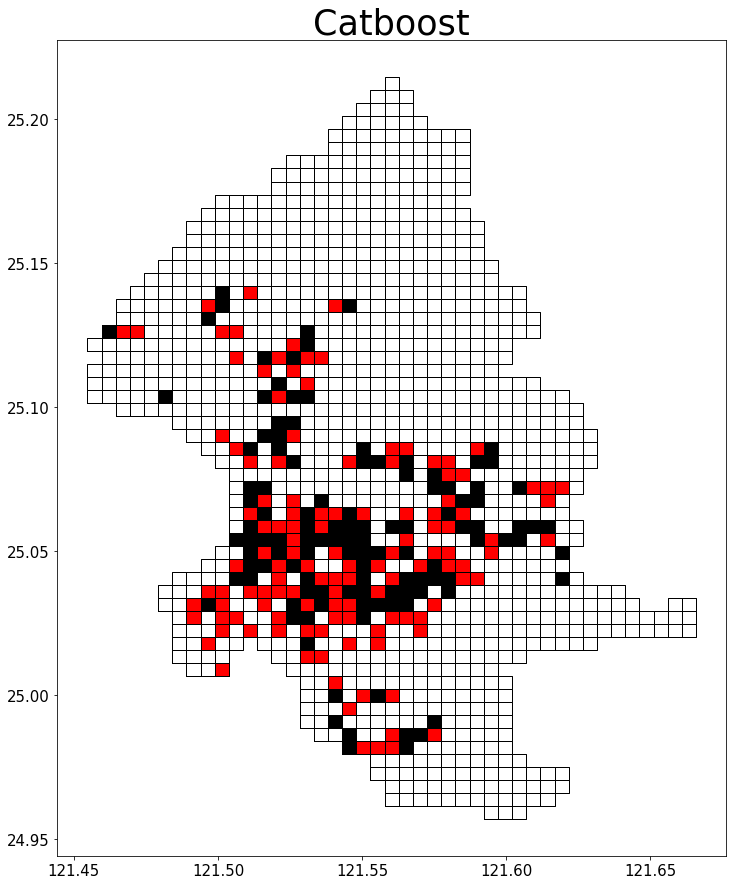

In [149]:
ax = gdf.plot(edgecolor='black',color='white',figsize=(20,15))
c = {'bed':'black','good':'red'}
catcgdf.plot(ax=ax,column='future',edgecolor='black',cmap=colors.ListedColormap(list(c.values())))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Catboost',fontsize=35)

### Extra Tree

In [17]:
for i in range(1,6):
    locals()['gdf'+str(i)],locals()['cgdf'+str(i)],locals()['train'+str(i)],locals()['va'+str(i)],locals()['mse'+str(i)] = all(ExtraTreesRegressor,locals()['test'+str(i)])
    print(f'test{i} finished')

<class 'sklearn.ensemble._forest.ExtraTreesRegressor'> :
validation : 2.4812923469387753
test :　2.3040416326530617

round :
2.306122448979592

change amount :
52

Accuracy :
193/245 = 0.7877551020408163

                                             geometry  bpre  real  pre  change
1   POLYGON ((121.55295 25.20550, 121.55295 25.210...   0.0     0  0.0       0
5   POLYGON ((121.55295 25.20098, 121.55295 25.205...   0.0     0  0.0       0
8   POLYGON ((121.54312 25.19647, 121.54312 25.200...   0.0     0  0.0       0
10  POLYGON ((121.55295 25.19647, 121.55295 25.200...   0.0     0  0.0       0
14  POLYGON ((121.53821 25.19195, 121.53821 25.196...   0.0     0  0.0       0
                                              geometry  bpre  real  pre  \
268  POLYGON ((121.54312 25.13326, 121.54312 25.137...  0.19     1  0.0   
311  POLYGON ((121.45958 25.12423, 121.45958 25.128...  0.14     1  0.0   
356  POLYGON ((121.52346 25.11972, 121.52346 25.124...  1.41     0  1.0   
381  POLYGON ((121.503

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<class 'sklearn.ensemble._forest.ExtraTreesRegressor'> :
validation : 2.23936887755102
test :　2.184098360655738

round :
2.25

change amount :
45

Accuracy :
199/244 = 0.8155737704918032

                                             geometry  bpre  real  pre  change
0   POLYGON ((121.55786 25.21001, 121.55786 25.214...   0.0     0  0.0       0
3   POLYGON ((121.56278 25.20550, 121.56278 25.210...   0.0     0  0.0       0
6   POLYGON ((121.55786 25.20098, 121.55786 25.205...   0.0     0  0.0       0
11  POLYGON ((121.55786 25.19647, 121.55786 25.200...   0.0     0  0.0       0
12  POLYGON ((121.56278 25.19647, 121.56278 25.200...   0.0     0  0.0       0
                                              geometry  bpre  real  pre  \
267  POLYGON ((121.53821 25.13326, 121.53821 25.137...  0.53     0  1.0   
325  POLYGON ((121.52838 25.12423, 121.52838 25.128...  0.00     1  0.0   
357  POLYGON ((121.52838 25.11972, 121.52838 25.124...  0.94     2  1.0   
387  POLYGON ((121.53329 25.11521, 121

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<class 'sklearn.ensemble._forest.ExtraTreesRegressor'> :
validation : 2.9000831632653052
test :　1.138272131147541

round :
1.1475409836065573

change amount :
44

Accuracy :
200/244 = 0.819672131147541

                                             geometry  bpre  real  pre  change
4   POLYGON ((121.54803 25.20098, 121.54803 25.205...   0.0     0  0.0       0
7   POLYGON ((121.56278 25.20098, 121.56278 25.205...   0.0     0  0.0       0
13  POLYGON ((121.56769 25.19647, 121.56769 25.200...   0.0     0  0.0       0
19  POLYGON ((121.56278 25.19195, 121.56278 25.196...   0.0     0  0.0       0
30  POLYGON ((121.56769 25.18744, 121.56769 25.191...   0.0     0  0.0       0
                                              geometry  bpre  real  pre  \
227  POLYGON ((121.48415 25.13778, 121.48415 25.142...  0.29     1  0.0   
414  POLYGON ((121.51855 25.11069, 121.51855 25.115...  0.72     0  1.0   
476  POLYGON ((121.52346 25.10166, 121.52346 25.106...  3.92    10  4.0   
565  POLYGON ((121.5234

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<class 'sklearn.ensemble._forest.ExtraTreesRegressor'> :
validation : 1.2629852040816325
test :　1.8435131147540984

round :
1.7950819672131149

change amount :
50

Accuracy :
194/244 = 0.7950819672131147

                                             geometry  bpre  real  pre  change
2   POLYGON ((121.55786 25.20550, 121.55786 25.210...   0.0     0  0.0       0
9   POLYGON ((121.54803 25.19647, 121.54803 25.200...   0.0     0  0.0       0
20  POLYGON ((121.56769 25.19195, 121.56769 25.196...   0.0     0  0.0       0
21  POLYGON ((121.57260 25.19195, 121.57260 25.196...   0.0     0  0.0       0
23  POLYGON ((121.58243 25.19195, 121.58243 25.196...   0.0     0  0.0       0
                                              geometry  bpre  real  pre  \
287  POLYGON ((121.49398 25.12875, 121.49398 25.133...  1.14     3  1.0   
319  POLYGON ((121.49889 25.12423, 121.49889 25.128...  1.77     0  2.0   
383  POLYGON ((121.51364 25.11521, 121.51364 25.119...  4.29     6  4.0   
385  POLYGON ((121.52

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<class 'sklearn.ensemble._forest.ExtraTreesRegressor'> :
validation : 1.929583801020408
test :　2.0640725409836067

round :
2.057377049180328

change amount :
55

Accuracy :
189/244 = 0.7745901639344263

                                             geometry  bpre  real  pre  change
22  POLYGON ((121.57752 25.19195, 121.57752 25.196...   0.0     0  0.0       0
35  POLYGON ((121.52838 25.18293, 121.52838 25.187...   0.0     0  0.0       0
36  POLYGON ((121.53329 25.18293, 121.53329 25.187...   0.0     0  0.0       0
40  POLYGON ((121.55295 25.18293, 121.55295 25.187...   0.0     0  0.0       0
53  POLYGON ((121.54803 25.17841, 121.54803 25.182...   0.0     0  0.0       0
                                              geometry  bpre  real  pre  \
203  POLYGON ((121.49398 25.14229, 121.49398 25.146...  0.95     0  1.0   
259  POLYGON ((121.49889 25.13326, 121.49889 25.137...  4.57     4  5.0   
281  POLYGON ((121.46450 25.12875, 121.46450 25.133...  0.53     0  1.0   
288  POLYGON ((121.4988

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [18]:
exgdf,excgdf,exmse = merg(gdf1,gdf2,gdf3,gdf4,gdf5,cgdf1,cgdf2,cgdf3,cgdf4,cgdf5,mse1,mse2,mse3,mse4,mse5)

                                            geometry  bpre  real  pre  change
0  POLYGON ((121.55786 25.21001, 121.55786 25.214...   0.0     0  0.0       0
1  POLYGON ((121.55295 25.20550, 121.55295 25.210...   0.0     0  0.0       0
2  POLYGON ((121.55786 25.20550, 121.55786 25.210...   0.0     0  0.0       0
3  POLYGON ((121.56278 25.20550, 121.56278 25.210...   0.0     0  0.0       0
4  POLYGON ((121.54803 25.20098, 121.54803 25.205...   0.0     0  0.0       0
(1221, 5)
                                              geometry  bpre  real  pre  \
203  POLYGON ((121.49398 25.14229, 121.49398 25.146...  0.95     0  1.0   
227  POLYGON ((121.48415 25.13778, 121.48415 25.142...  0.29     1  0.0   
259  POLYGON ((121.49889 25.13326, 121.49889 25.137...  4.57     4  5.0   
267  POLYGON ((121.53821 25.13326, 121.53821 25.137...  0.53     0  1.0   
268  POLYGON ((121.54312 25.13326, 121.54312 25.137...  0.19     1  0.0   

     change future  
203       1   good  
227       1    bed  
259     

In [19]:
print(catgdf.shape)
exgdf

(1221, 5)


,geometry,bpre,real,pre,change
0,"POLYGON ((121.55786 25.21001, 121.55786 25.214...",0.00,0,0.0,0
1,"POLYGON ((121.55295 25.20550, 121.55295 25.210...",0.00,0,0.0,0
2,"POLYGON ((121.55786 25.20550, 121.55786 25.210...",0.00,0,0.0,0
3,"POLYGON ((121.56278 25.20550, 121.56278 25.210...",0.00,0,0.0,0
4,"POLYGON ((121.54803 25.20098, 121.54803 25.205...",0.00,0,0.0,0
5,"POLYGON ((121.55295 25.20098, 121.55295 25.205...",0.00,0,0.0,0
6,"POLYGON ((121.55786 25.20098, 121.55786 25.205...",0.00,0,0.0,0
7,"POLYGON ((121.56278 25.20098, 121.56278 25.205...",0.00,0,0.0,0
8,"POLYGON ((121.54312 25.19647, 121.54312 25.200...",0.00,0,0.0,0
9,"POLYGON ((121.54803 25.19647, 121.54803 25.200...",0.00,0,0.0,0


In [20]:
print(catcgdf.shape)
excgdf

(241, 6)


,geometry,bpre,real,pre,change,future
203,"POLYGON ((121.49398 25.14229, 121.49398 25.146...",0.95,0,1.0,1,good
227,"POLYGON ((121.48415 25.13778, 121.48415 25.142...",0.29,1,0.0,1,bed
259,"POLYGON ((121.49889 25.13326, 121.49889 25.137...",4.57,4,5.0,1,good
267,"POLYGON ((121.53821 25.13326, 121.53821 25.137...",0.53,0,1.0,1,good
268,"POLYGON ((121.54312 25.13326, 121.54312 25.137...",0.19,1,0.0,1,bed
281,"POLYGON ((121.46450 25.12875, 121.46450 25.133...",0.53,0,1.0,1,good
287,"POLYGON ((121.49398 25.12875, 121.49398 25.133...",1.14,3,1.0,1,bed
288,"POLYGON ((121.49889 25.12875, 121.49889 25.133...",4.75,4,5.0,1,good
311,"POLYGON ((121.45958 25.12423, 121.45958 25.128...",0.14,1,0.0,1,bed
312,"POLYGON ((121.46450 25.12423, 121.46450 25.128...",1.15,0,1.0,1,good


In [113]:
map = folium.Map(location = [25.055,121.55] , zoom_start = 12)
c = {'bed':'black','good':'red'}
excgdf.explore(m=map,column='future',cmap=colors.ListedColormap(list(c.values())))

In [123]:
#三者都有異
map = folium.Map(location = [25.06,121.55] , zoom_start = 11.5)
c = {'bed':'black','good':'red'}
over = xgcgdf.overlay(catcgdf, how="intersection")
over = over.overlay(excgdf,how="intersection")
m = over.explore(column='future',m=map,cmap=colors.ListedColormap(list(c.values())))
m.save('map\cross.html')
m

C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:2197: UserWarning: `keep_geom_type=True` in overlay resulted in 1102 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  self, right, how=how, keep_geom_type=keep_geom_type, make_valid=make_valid
C:\ProgramData\Anaconda3\envs\howard\lib\site-packages\geopandas\geodataframe.py:2197: UserWarning: `keep_geom_type=True` in overlay resulted in 988 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  self, right, how=how, keep_geom_type=keep_geom_type, make_valid=make_valid


In [121]:
over

,bpre_1,real_1,pre_1,change_1,future_1,bpre_2,real_2,pre_2,change_2,future_2,bpre,real,pre,change,future,geometry
0,-0.064620,1,0.0,1,bed,0.023165,1,0.0,1,bed,0.19,1,0.0,1,bed,"POLYGON ((121.54803 25.13778, 121.54803 25.133..."
1,0.964577,3,1.0,1,bed,1.019212,3,1.0,1,bed,1.14,3,1.0,1,bed,"POLYGON ((121.49889 25.13326, 121.49889 25.128..."
2,1.531853,0,2.0,1,good,1.826290,0,2.0,1,good,1.77,0,2.0,1,good,"POLYGON ((121.50381 25.12875, 121.50381 25.124..."
3,0.044650,1,0.0,1,bed,0.022134,1,0.0,1,bed,0.14,1,0.0,1,bed,"POLYGON ((121.46450 25.12875, 121.46450 25.124..."
4,0.887274,0,1.0,1,good,1.431223,0,1.0,1,good,1.15,0,1.0,1,good,"POLYGON ((121.46941 25.12875, 121.46941 25.124..."
5,6.567430,0,7.0,1,good,5.042780,0,5.0,1,good,4.12,0,4.0,1,good,"POLYGON ((121.47432 25.12875, 121.47432 25.124..."
6,-0.045943,1,0.0,1,bed,-0.032875,1,0.0,1,bed,0.00,1,0.0,1,bed,"POLYGON ((121.53329 25.12875, 121.53329 25.124..."
7,1.479828,0,1.0,1,good,0.891516,0,1.0,1,good,1.41,0,1.0,1,good,"POLYGON ((121.52838 25.12423, 121.52838 25.119..."
8,0.715099,2,1.0,1,bed,0.656876,2,1.0,1,bed,0.94,2,1.0,1,bed,"POLYGON ((121.53329 25.12423, 121.53329 25.119..."
9,8.956993,1,9.0,1,good,4.999740,1,5.0,1,good,5.72,1,6.0,1,good,"POLYGON ((121.52346 25.11972, 121.52346 25.115..."


Text(0.5, 1.0, 'Extra Tree')

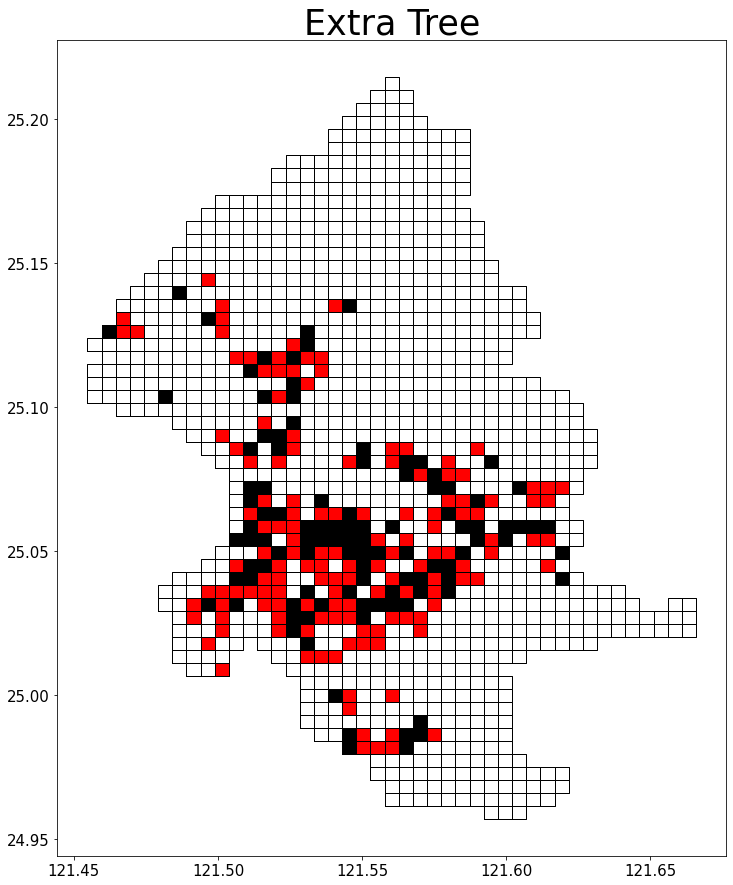

In [150]:
ax = gdf.plot(edgecolor='black',color='white',figsize=(20,15))
c = {'bed':'black','good':'red'}
excgdf.plot(ax=ax,column='future',edgecolor='black',cmap=colors.ListedColormap(list(c.values())))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Extra Tree',fontsize=35)

In [125]:
over.to_file('cross.shp')